# TP 3 Graph Frames

## Team members:
- Lovato Edoardo 12515068
- Markhovski Julia 12514030
- Piccoli Leonardo Arduino 12515079

In [1]:
import pyspark
from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.window import Window

# Prepare the Spark builder
builder = pyspark.sql.SparkSession.builder.appName("Graphs_Practice") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder,extra_packages=["graphframes:graphframes:0.8.4-spark3.5-s_2.12"]).getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", spark._sc.defaultParallelism)

spark.conf.set("spark.sql.repl.eagerEval.enabled",True) # OK for exploration, not great for performance
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

from graphframes import GraphFrame

spark.sparkContext.setLogLevel("WARN")

Load dataset

In [2]:
# Put CSVs in a path accessible by Spark
YEAR = 2018  # year can be changed to 2009...2018 or set a list of files
csvPath = f"input/{YEAR}.csv"

# If want to merge many years:
# files = [f"input/{y}.csv" for y in range(2009, 2019)]
# csv_path = files

### Read csv and create graph

In [3]:
# Read CSV
df = spark.read.option("header", "true").option("inferSchema", "true").csv(csvPath)

# Show columns to confirm
print(df.columns)
df.select("ORIGIN", "DEST").show(5, truncate=False)

['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
+------+----+
|ORIGIN|DEST|
+------+----+
|EWR   |DEN |
|LAS   |SFO |
|SNA   |DEN |
|RSW   |ORD |
|ORD   |ALB |
+------+----+
only showing top 5 rows



Build edges and vertices DataFrames for GraphFrame

In [4]:
# Normalize column names and drop malformed rows
flights = df.select(
    F.col("ORIGIN").alias("origin"),
    F.col("DEST").alias("dest")
).na.drop(subset=["origin", "dest"])

# If airport codes are numeric in CSV (IDs) convert to string consistent type:
flights = flights.withColumn("origin", F.col("origin").cast("string")) \
                 .withColumn("dest", F.col("dest").cast("string"))

# Create edges with weights = number of flights between pair (origin -> dest)
edges = flights.groupBy(F.col("origin").alias("src"), F.col("dest").alias("dst")) \
               .agg(F.count("*").alias("weight"))

# Create vertices: unique airports
verts = (edges.select(F.col("src").alias("id"))
                .union(edges.select(F.col("dst").alias("id")))
                .distinct())

# Show basic info
print("Vertices count:", verts.count())
print("Edges count:", edges.count())

# Build GraphFrame
graph = GraphFrame(verts, edges)

Vertices count: 358
Edges count: 6365


Graph visualization

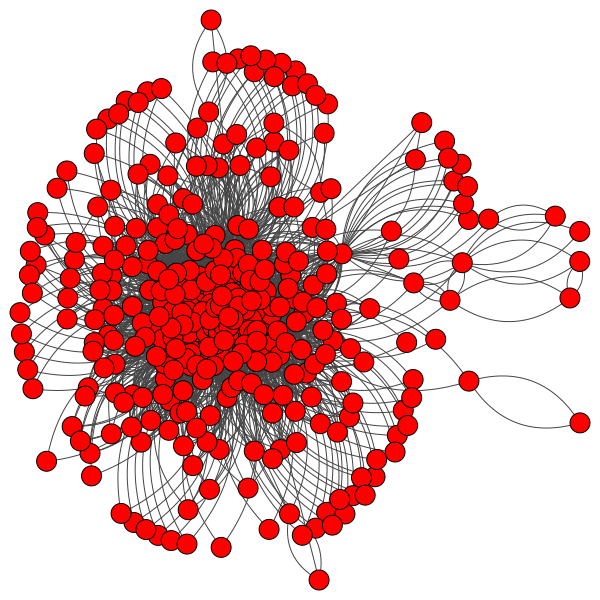

In [5]:
from igraph import *
ig = Graph.TupleList(graph.edges.collect(), directed=False)
plot(ig)

### Task 1: In-degree, Out-degree, Total degree

We can decide whether we only consider the connected airports (thus only the number of edges or whether we also consider the number of flights)

In [6]:
# Out-degree: number of outgoing edges (or sum of weights)
outdeg = edges.groupBy("src").agg(
    F.count("*").alias("out_degree_unweighted"),
    F.sum("weight").alias("out_degree_weighted")
).withColumnRenamed("src", "id")

# In-degree: number of incoming edges (or sum of weights)
indeg = edges.groupBy("dst").agg(
    F.count("*").alias("in_degree_unweighted"),
    F.sum("weight").alias("in_degree_weighted")
).withColumnRenamed("dst", "id")

# Total degree = in + out (we'll join on id)
deg = verts.join(indeg, on="id", how="left") \
           .join(outdeg, on="id", how="left") \
           .na.fill(0, subset=["in_degree_unweighted", "in_degree_weighted",
                               "out_degree_unweighted", "out_degree_weighted"])

deg = deg.withColumn("total_degree_unweighted",
                     F.col("in_degree_unweighted") + F.col("out_degree_unweighted")) \
         .withColumn("total_degree_weighted",
                     F.col("in_degree_weighted") + F.col("out_degree_weighted"))

# Show top airports by total weighted degree
deg.orderBy(F.desc("total_degree_weighted")).show(10, truncate=False)

+---+--------------------+------------------+---------------------+-------------------+-----------------------+---------------------+
|id |in_degree_unweighted|in_degree_weighted|out_degree_unweighted|out_degree_weighted|total_degree_unweighted|total_degree_weighted|
+---+--------------------+------------------+---------------------+-------------------+-----------------------+---------------------+
|ATL|167                 |390079            |166                  |390046             |333                    |780125               |
|ORD|175                 |332942            |174                  |332953             |349                    |665895               |
|DFW|169                 |279272            |170                  |279298             |339                    |558570               |
|DEN|164                 |236020            |162                  |235989             |326                    |472009               |
|CLT|136                 |233309            |136              

### Task 1, 2: Triangles per node and total number of triangles

In [7]:
# Approach:
#   1) Convert directed edges into undirected unique edges with src < dst (lexicographic)
#   2) For undirected edges E (a,b), find paths a-b-c via joins (E as e1, E as e2 where e1.b = e2.a)
#   3) Check for closure (edge a-c exists), count each triangle once and then divide by 1 (we will ensure ordering to avoid duplicates)
#   We will ensure vertex ordering a < b < c so that each triangle is counted exactly once

# Create undirected edges with consistent ordering
undirected = edges.select(
    F.when(F.col("src") < F.col("dst"), F.col("src")).otherwise(F.col("dst")).alias("v1"),
    F.when(F.col("src") < F.col("dst"), F.col("dst")).otherwise(F.col("src")).alias("v2")
).select(F.col("v1").alias("src"), F.col("v2").alias("dst")).distinct().cache()

# e1: (a,b), e2: (b,c). Join on e1.dst == e2.src to produce (a,b,c) with a < b and b < c possible
e1 = undirected.alias("e1")
e2 = undirected.alias("e2")
e3 = undirected.alias("e3")

# join e1.e2 where e1.dst == e2.src and ensure ordering a < b < c
paths = e1.join(e2, F.col("e1.dst") == F.col("e2.src")) \
          .select(F.col("e1.src").alias("a"),
                  F.col("e1.dst").alias("b"),
                  F.col("e2.dst").alias("c"))

# Keep only a < b and b < c (this reduces duplicates)
paths_filtered = paths.filter((F.col("a") < F.col("b")) & (F.col("b") < F.col("c")))

# Now check closure: edge (a,c) exists
triangles = paths_filtered.join(undirected.alias("e3"),
                                (F.col("a") == F.col("e3.src")) & (F.col("c") == F.col("e3.dst")),
                                how="inner").select("a","b","c")

trianglesPerNode = (
    triangles.select(F.col("a").alias("id"))
    .union(triangles.select(F.col("b").alias("id")))
    .union(triangles.select(F.col("c").alias("id")))
)

nodeTriangleCount = (
    trianglesPerNode
    .groupBy("id")
    .agg(F.count("*").alias("triangle_count"))
)

# Triangles per node
nodeTriangleCount.show(10, truncate=False)

# Total triangles count
triangle_count = triangles.count()
print("Number of total undirected triangles (unique a<b<c):", triangle_count)

+---+--------------+
|id |triangle_count|
+---+--------------+
|ANC|134           |
|BOS|1248          |
|BTV|40            |
|JFK|1079          |
|COU|3             |
|JAX|588           |
|MEM|308           |
|CWA|3             |
|FCA|35            |
|BOI|177           |
+---+--------------+
only showing top 10 rows

Number of undirected triangles (unique a<b<c): 24120


### Task 3: Centrality measure of our choice
Eigenvector centrality (power iteration) implemented natively. Due to the high computational cost of iterative joins on the full graph, the analysis was restricted to the top 20% of airports ranked by degree. This reduction was applied only for Task 3 and does not affect previous results.

In [8]:
# How much of the graph to keep (percentage of top-degree airports)
KEEP_RATIO = 0.2  # 20% of highest-degree vertices (safe default)

In [9]:
spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")

# Use total unweighted degree from Task 2
deg_task3 = deg.select("id", "total_degree_unweighted")

# Reduce graph locally: keep top KEEP_RATIO-% of vertices by degree
num_keep = int(deg_task3.count() * KEEP_RATIO)

top_vertices = deg_task3.orderBy(
    F.desc("total_degree_unweighted")
).limit(num_keep).select("id")

# Reduced vertices
verts_t3 = verts.join(top_vertices, on="id")

# Reduced undirected edges
edges_t3 = undirected.join(
    top_vertices.withColumnRenamed("id", "src"), "src"
).join(
    top_vertices.withColumnRenamed("id", "dst"), "dst"
)

# Build adjacency ONCE (undirected)
adj = edges_t3.select(
    F.col("src").alias("from"),
    F.col("dst").alias("to")
).union(
    edges_t3.select(
        F.col("dst").alias("from"),
        F.col("src").alias("to")
    )
).cache()

adj.count()  # materialize

# Power iteration
N = verts_t3.count()
x = verts_t3.select("id").withColumn("score", F.lit(1.0 / N)).cache()
x.count()

numIter = 30

for i in range(numIter):
    contribs = adj.join(
        x,
        adj["from"] == x["id"]
    ).select(
        F.col("to").alias("id"),
        F.col("score").alias("contrib")
    )

    x_new = contribs.groupBy("id").agg(
        F.sum("contrib").alias("score")
    )

    # Normalize (L2 norm)
    norm = x_new.select(
        F.sqrt(F.sum(F.col("score") * F.col("score"))).alias("norm")
    ).collect()[0]["norm"]

    if norm is None or norm == 0:
        break

    x_new = x_new.withColumn("score", F.col("score") / F.lit(norm))

    # Cut lineage
    x.unpersist()
    x = x_new.checkpoint(eager=True).cache()
    x.count()

x.orderBy(F.desc("score")).show(10, truncate=False)

+---+-------------------+
|id |score              |
+---+-------------------+
|ATL|0.163773629891444  |
|MSP|0.16024135552836674|
|DEN|0.15996868427662997|
|DFW|0.15853242679192833|
|CLT|0.15814546346263916|
|ORD|0.15500015242885107|
|MCO|0.15401031946138785|
|DTW|0.15339130107904067|
|LAS|0.1533284406921156 |
|IAH|0.1528862660189396 |
+---+-------------------+
only showing top 10 rows



### Task 4: PageRank algorithm

In [10]:
# PageRank implemented natively (DataFrame iterative algorithm)
# We'll implement the standard PageRank update:
# rank_new(v) = (1 - d)/N + d * sum_{u in inNeighbors(v)} rank(u) / outdeg(u)
# Implementation details:
# - Use edge weights (if you want) to distribute contribution proportionally; here we use weight as multiplicative
# - We compute outdeg_sum per src for distribution
# - Use damping factor d and iteration count

d = 0.85
num_iter = 20
# Number of vertices
N = verts.count()
N_float = float(N)

# Initialize ranks uniformly
ranks = verts.select("id").withColumn("rank", F.lit(1.0 / N_float))

# Precompute outdegree sums (using weighted out-degree so that weight influences distribution)
outWeight = edges.groupBy("src").agg(F.sum("weight").alias("outWeightSum"))

# Join edges with outWeight to compute contribution fraction
edgesWithOut = edges.join(outWeight, on="src", how="left") \
                      .withColumn("fraction", F.col("weight") / F.col("outWeightSum"))

# Iterations
for i in range(num_iter):
    # join ranks (src -> rank) to edges to compute contributions to dst
    contribs = ranks.alias("r").join(edgesWithOut.alias("e"), F.col("r.id") == F.col("e.src")) \
                      .select(F.col("e.dst").alias("id"),
                              (F.col("r.rank") * F.col("e.fraction")).alias("contrib"))
    # sum contributions per dst
    summed = contribs.groupBy("id").agg(F.sum("contrib").alias("sum_contrib"))
    # apply PageRank formula
    ranks = verts.select("id").join(summed, on="id", how="left") \
                 .na.fill(0.0, subset=["sum_contrib"]) \
                 .withColumn("rank", (1.0 - d) / N_float + d * F.col("sum_contrib")) \
                 .select("id", "rank")
    # (optional) normalize ranks to sum to 1 for numerical stability
    totalRank = ranks.agg(F.sum("rank").alias("s")).collect()[0]["s"]
    ranks = ranks.withColumn("rank", F.col("rank") / F.lit(totalRank))

# Show top airports by PageRank
ranks.orderBy(F.desc("rank")).show(10, truncate=False)

+---+--------------------+
|id |rank                |
+---+--------------------+
|ATL|0.04760046864997547 |
|ORD|0.043286403624845725|
|DFW|0.04030422655196742 |
|DEN|0.032696480673798406|
|CLT|0.029355975550382253|
|LAX|0.02446600949942706 |
|MSP|0.023037639491272383|
|IAH|0.021175992382990443|
|DTW|0.02099787419058001 |
|SFO|0.02069896583975706 |
+---+--------------------+
only showing top 10 rows



Another possibility - RDD-based PageRank (Functional/MapReduce style)

In [11]:
# Setup constants
d = 0.85
num_iter = 20
N = float(verts.count())

# Prepare the Graph Structure as RDDs
# We need an adjacency list structure: (src, [(dst, weight), (dst, weight), ...]) and we need the total output weight per source to normalize contributions.

# Map: (src, (dst, weight))
edges_rdd = edges.select("src", "dst", "weight").rdd.map(lambda r: (r[0], (r[1], r[2])))

# Compute total out-weight per src: (src, total_weight)
out_weights = edges_rdd.map(lambda x: (x[0], x[1][1])) \
                       .reduceByKey(lambda a, b: a + b)

# Create the detailed adjacency list: (src, ([(dst, w), ...], total_out_weight))
# We perform a join between the edges and the total weights
adjacency_list = edges_rdd.groupByKey() \
                          .join(out_weights) \
                          .cache() # Cache this! It stays static during iterations.

# Initialize Ranks
# Format: (id, rank)
ranks = verts.select("id").rdd.map(lambda r: (r[0], 1.0 / N))

# Iterative Update
for i in range(num_iter):
    # Join graph structure with current ranks
    # Result of join: (src, ( ([(dst, w)...], total_w), current_rank ))
    
    # The flatMap function calculates contributions:
    # For a node 'src', it sends 'current_rank * (w / total_w)' to 'dst'
    def compute_contribs(node_data):
        (src, ((neighbors, total_w), rank)) = node_data
        results = []
        for dst, weight in neighbors:
            contribution = rank * (weight / total_w)
            results.append((dst, contribution))
        return results

    contribs = adjacency_list.join(ranks).flatMap(compute_contribs)

    # Sum contributions by destination and apply formula
    # We use fullOuterJoin with the vertices to ensure nodes with no incoming edges don't disappear
    # (Though in a connected component this is less of an issue, standard PR handles it)
    
    ranks = contribs.reduceByKey(lambda a, b: a + b) \
                    .mapValues(lambda sum_contrib: (1 - d) / N + d * sum_contrib)

# Convert back to DataFrame for display
results_rdd = ranks.toDF(["id", "rank"])
results_rdd.orderBy(F.desc("rank")).show(10, truncate=False)

+---+--------------------+
|id |rank                |
+---+--------------------+
|ATL|0.04760046864997549 |
|ORD|0.04328640362484572 |
|DFW|0.04030422655196742 |
|DEN|0.032696480673798434|
|CLT|0.029355975550382274|
|LAX|0.02446600949942707 |
|MSP|0.023037639491272396|
|IAH|0.021175992382990446|
|DTW|0.020997874190580013|
|SFO|0.02069896583975707 |
+---+--------------------+
only showing top 10 rows



### Task 5, 6: Most connected airports and most important airports

In [13]:
# Ensure PageRank result is a DataFrame
if not isinstance(ranks, DataFrame):
    print("Converting PageRank ranks from RDD to DataFrame...")
    ranks = ranks.map(lambda x: (x[0], float(x[1]))).toDF(["id", "rank"])

# Join degree, PageRank, eigenvector centrality
results = deg.select(
                "id",
                "in_degree_weighted",
                "out_degree_weighted",
                "total_degree_weighted"
          ) \
          .join(ranks, on="id", how="left") \
          .join(
                x.withColumnRenamed("score", "eigen_centrality"),
                on="id",
                how="left"
          ) \
          .na.fill(0, subset=["rank", "eigen_centrality"])

# Display results
print("Top by total degree (most connected airports):")
results.orderBy(F.desc("total_degree_weighted")) \
       .show(15, truncate=False)

print("Top by PageRank (most important airports):")
results.orderBy(F.desc("rank")) \
       .show(15, truncate=False)

print("Top by Eigenvector Centrality (most important airports):")
results.orderBy(F.desc("eigen_centrality")) \
       .show(15, truncate=False)

Converting PageRank ranks from RDD to DataFrame...
Top by total degree (most connected airports):
+---+------------------+-------------------+---------------------+--------------------+-------------------+
|id |in_degree_weighted|out_degree_weighted|total_degree_weighted|rank                |eigen_centrality   |
+---+------------------+-------------------+---------------------+--------------------+-------------------+
|ATL|390079            |390046             |780125               |0.04760046864997549 |0.163773629891444  |
|ORD|332942            |332953             |665895               |0.04328640362484572 |0.15500015242885107|
|DFW|279272            |279298             |558570               |0.04030422655196742 |0.15853242679192833|
|DEN|236020            |235989             |472009               |0.032696480673798434|0.15996868427662997|
|CLT|233309            |233317             |466626               |0.029355975550382274|0.15814546346263916|
|LAX|221516            |221486        

### Task 7: Comparison with Native Methods

In [15]:
print("=" * 50)
print("1. DEGREE COMPARISON")
print("=" * 50)

# Library Calculation
lib_in = graph.inDegrees
lib_out = graph.outDegrees

lib_total = lib_in.join(lib_out, "id", "outer") \
    .select(
        "id",
        (
            F.coalesce(F.col("inDegree"), F.lit(0)) +
            F.coalesce(F.col("outDegree"), F.lit(0))
        ).alias("lib_total_unweighted")
    )

print("--- Top 5 Manual Total Degrees (UNWEIGHTED) ---")
deg.select("id", "total_degree_unweighted") \
   .orderBy(F.desc("total_degree_unweighted")) \
   .show(5, truncate=False)

print("--- Top 5 Library Total Degrees (GraphFrames UNWEIGHTED) ---")
lib_total.orderBy(F.desc("lib_total_unweighted")) \
         .show(5, truncate=False)

print("\nNOTE: GraphFrames degrees are unweighted by default.\n")

print("=" * 50)
print("2. TRIANGLE COUNT COMPARISON")
print("=" * 50)

# Library Calculation
native_triangles = graph.triangleCount()
lib_triangle_count = int(
    native_triangles.select(F.sum("count")).first()[0] / 3
)

# Manual value
manual_triangle_val = 24120  # replace if stored in a variable

print(f"Manual Triangle Count:  {manual_triangle_val}")
print(f"Library Triangle Count: {lib_triangle_count}")

if manual_triangle_val == lib_triangle_count:
    print("Triangle counts match perfectly!")
else:
    print(f">> WARNING: Mismatch of {abs(manual_triangle_val - lib_triangle_count)} triangles.")


print("\n" + "=" * 50)
print("3. PAGERANK COMPARISON")
print("=" * 50)

# Ensure 'ranks' is a DataFrame
if not isinstance(ranks, DataFrame):
    print("Converting PageRank result from RDD to DataFrame...")
    ranks = ranks.map(lambda x: (x[0], float(x[1]))) \
                 .toDF(["id", "rank"])

# Library Calculation
lib_pr_results = graph.pageRank(
    resetProbability=0.15,
    maxIter=20
)

lib_pr_top = lib_pr_results.vertices \
    .orderBy(F.desc("pagerank")) \
    .limit(5)

# Comparison
print("--- Top 5 Manual PageRank ---")
ranks.orderBy(F.desc("rank")) \
     .show(5, truncate=False)

print("--- Top 5 Library PageRank (GraphFrames) ---")
lib_pr_top.select("id", "pagerank") \
          .show(5, truncate=False)

print("\nNOTE:")
print("- Absolute PageRank values may differ due to normalization.")
print("- Relative ranking should be similar if implementation is correct.")

1. DEGREE COMPARISON
--- Top 5 Manual Total Degrees (UNWEIGHTED) ---
+---+-----------------------+
|id |total_degree_unweighted|
+---+-----------------------+
|ORD|349                    |
|DFW|339                    |
|ATL|333                    |
|DEN|326                    |
|CLT|272                    |
+---+-----------------------+
only showing top 5 rows

--- Top 5 Library Total Degrees (GraphFrames UNWEIGHTED) ---
+---+--------------------+
|id |lib_total_unweighted|
+---+--------------------+
|ORD|349                 |
|DFW|339                 |
|ATL|333                 |
|DEN|326                 |
|CLT|272                 |
+---+--------------------+
only showing top 5 rows


NOTE: GraphFrames degrees are unweighted by default.

2. TRIANGLE COUNT COMPARISON
Manual Triangle Count:  24120
Library Triangle Count: 24120
Triangle counts match perfectly!

3. PAGERANK COMPARISON
--- Top 5 Manual PageRank ---
+---+--------------------+
|id |rank                |
+---+-----------------

### Task 8: Flights heatmap

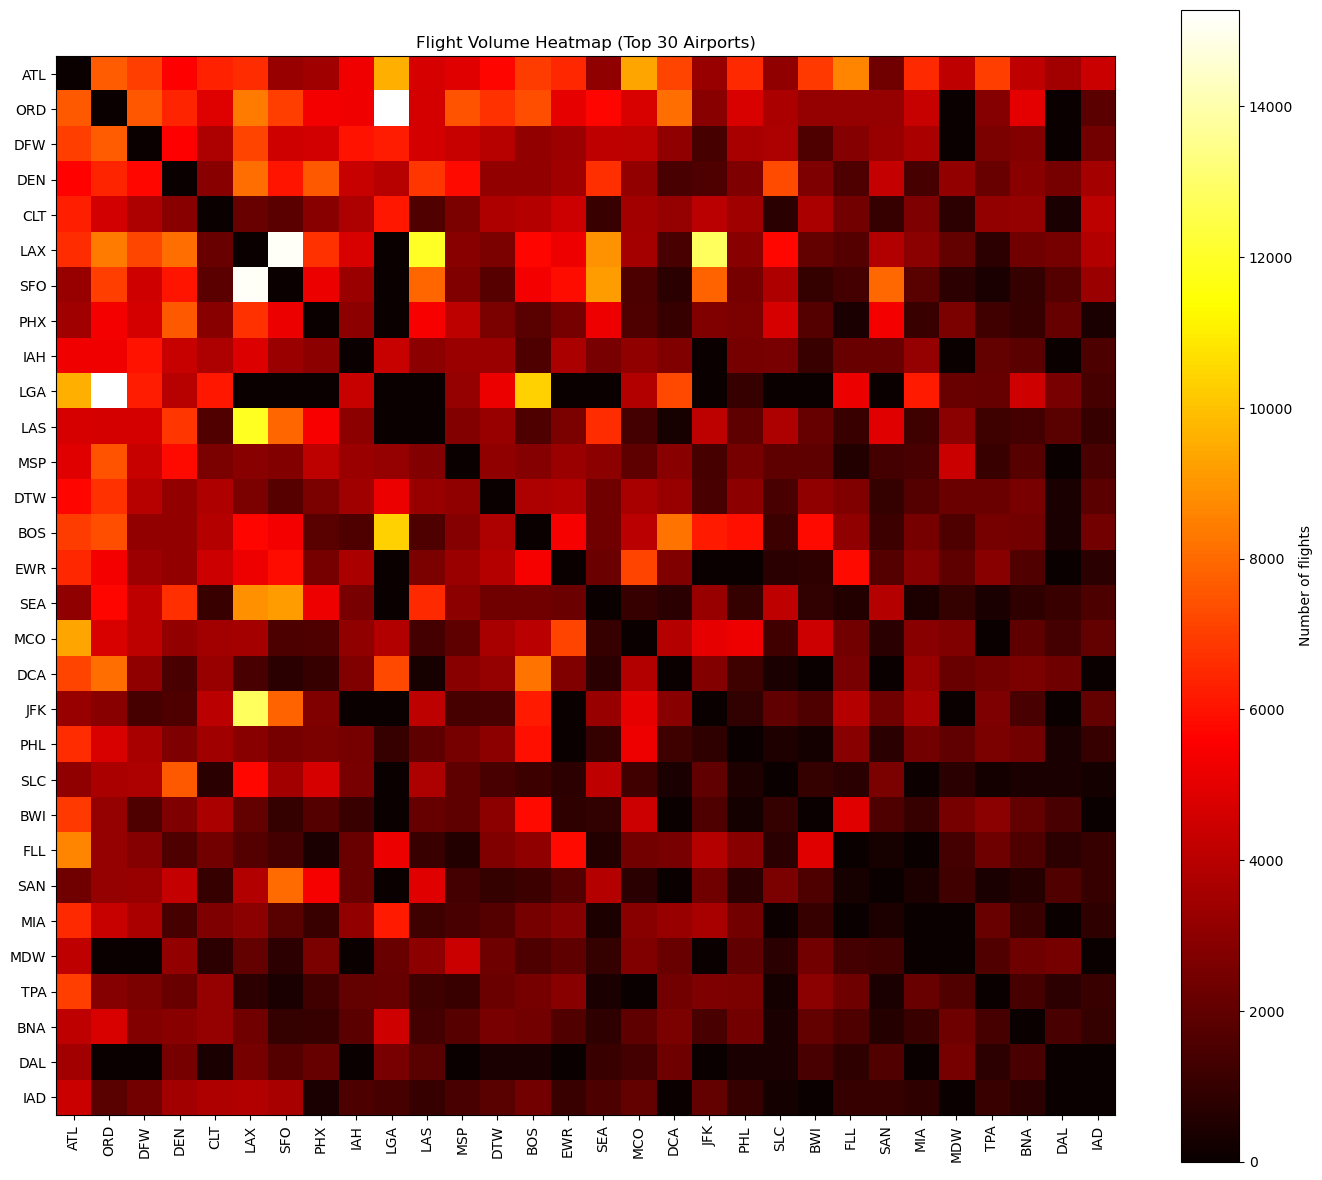

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Only show top 30 most connected airports
topAirports = (
    edges.groupBy("src")
    .agg(F.sum("weight").alias("total_weight"))
    .orderBy(F.desc("total_weight"))
    .limit(30)
)

# Variable defined as 'topIds' here
topIds = [r["src"] for r in topAirports.collect()]

# CORRECTED: Changed 'top_ids' to 'topIds' to match definition
edges_top = edges.filter(
    F.col("src").isin(topIds) & F.col("dst").isin(topIds)
)

pdf = edges_top.toPandas()

heatmap_df = pdf.pivot_table(
    index="src",
    columns="dst",
    values="weight",
    fill_value=0
)

heatmap_df = heatmap_df.reindex(
    index=topIds,
    columns=topIds,
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(14, 12))
plt.imshow(heatmap_df.values, cmap='hot', interpolation='nearest') # Added cmap for better visuals
plt.xticks(range(len(topIds)), topIds, rotation=90)
plt.yticks(range(len(topIds)), topIds)
plt.colorbar(label="Number of flights")
plt.title("Flight Volume Heatmap (Top 30 Airports)")
plt.tight_layout()
plt.show()